# Implementación del algoritmo K-means++ con cálculo del número de clústeres relativamente oṕtimo para puntos con movimiento aleatorio y predicción de cambio en el tiempo.

A diferencia con los otros notebooks, este se va a utlizar para mostrar el algoritmo completo, como si de un único archivo se tratase. Con ello podemos controlar mejor la ejecución del algoritmo.

Importamos las librerías que vamos a emplear, cargamos y representamos los puntos:

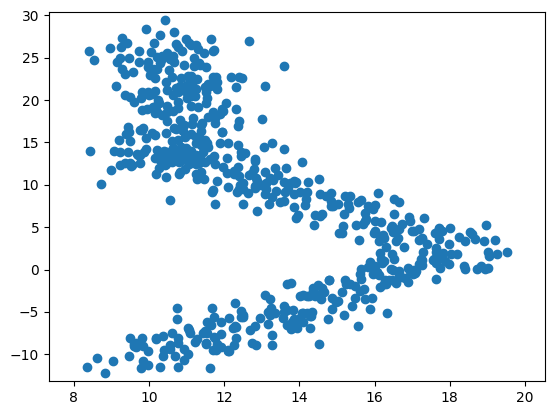

In [5]:
import matplotlib.pyplot as plt
import random
import math
from sklearn import metrics

with open("Datasets/dataset1.csv") as input_file:
    input_values = input_file.read()

x = [] # Lista de valores x
y = [] # Lista de valores y
point_class = [] # Lista de valores de los puntos
input_offset = 3
input_values = input_values.splitlines()[1 :: ]
for point in input_values:
    splitted_point = point.split(",")
    x.append(float(splitted_point[0]))
    y.append(float(splitted_point[1]))
    point_class.append(float(splitted_point[2]))

y_axis_limits = (min(y), max(y))
x_axis_limits = (min(x), max(x))
plt.ylim(y_axis_limits[0] - 1, y_axis_limits[1] + 1)
plt.xlim(x_axis_limits[0] - 1, x_axis_limits[1] + 1)
plt.scatter(x, y)
plt.show()


Implementamos el algoritmo:

In [6]:
def mean(list): # Función que calcula la media de una lista
    acc = 0
    for i in list:
        acc = acc + i
    return acc/len(list)

def initialize(k="Number of centroids", d="Data points"):
    centroids = []
    point_distance_to_centroids = [[]] # Guarda la distancia de cada punto a cada centroide
    
    # Escojo como primer centroide el valor más cercano a la media
    mean_x_coord = mean(d[0])
    mean_y_coord = mean(d[1])
    for point_index in range(len(d[0])): # Calculo la distancia 
        point_distance_to_centroids[0].append(abs(math.sqrt((mean_x_coord - d[0][point_index]) ** 2) + ((mean_y_coord - d[1][point_index]) ** 2)))
    
    # Una vez calculadas todas las distancias escogemos el primer centro:
    point_position = point_distance_to_centroids[0].index(min(point_distance_to_centroids[0]))
    centroids.append((d[0][point_position], d[1][point_position], point_class[point_position]))
    
    point_distance_to_centroids[0].clear() # Borro las distancias a la media

    # Calculo la distancia de todos los puntos al primer centroide
    for point_index in range(len(d[0])):
        point_distance_to_centroids[0].append(abs(math.sqrt((centroids[0][0] - d[0][point_index]) ** 2) + ((centroids[0][1] - d[1][point_index]) ** 2)))

    assigned_centroid = [0 for i in range(len(d[0]))] # Captura el índice del centroide al que se asignará cada punto
    
    
    # Calculo el siguiente centroide, que va a ser el punto más lejano de de entre todos los centroides ya calculados anteriormente
    for n_centroid in range(1, k):
        max_distant_point_distance = [] # Contiene las distancias a los puntos más lejanos de cada centroide
        furthest_distance = 0
        for centroid_distances in point_distance_to_centroids:
            max_distant_point_distance.append(max(centroid_distances))
        
        furthest_distance = max(max_distant_point_distance)
        centroid_with_furthest_point = max_distant_point_distance.index(furthest_distance)

        # Ahora capturo el punto más lejando del centroide
        furthest_point_index = point_distance_to_centroids[centroid_with_furthest_point].index(furthest_distance)
        # Ahora que ya tengo el punto más lejano del centroide, procedo a añadirlo como centroide nuevo

        centroids.append((d[0][furthest_point_index], d[1][furthest_point_index], d[2][furthest_point_index]))

        # Una vez añadido el centroide, recalculo las distancias y asignaciones de los puntos.
        point_distance_to_centroids.append([])
        for point_index in range(len(assigned_centroid)): # Calculo las distancias al nuevo centroide
            point_distance_to_centroids[n_centroid].append(abs(math.sqrt((centroids[n_centroid][0] - d[0][point_index]) ** 2) + ((centroids[n_centroid][1] - d[1][point_index]) ** 2)))

        # Reasignamos los puntos que pertencen a un centroide, a otro, siempre y cuando la distancia mínima sea <= 0,
        # ya que si un centroide tiene una distancia de -1 unidades a un punto, entonces se considera que ese punto no tiene
        # ese centroide como el más cercano y por tanto, está asignado a otro centroide.
        for i in range(len(assigned_centroid)):
            centroids_max_distances = []
            for j in range(len(point_distance_to_centroids)):
                centroids_max_distances.append(point_distance_to_centroids[j][i])
            assigned_centroid[i] = centroids_max_distances.index(min(filter(lambda x : x >= 0, centroids_max_distances))) # Asignamos al punto el centroide más cercano
        
        # Una vez reasignados los puntos de clúster, reasigno las distancias asignando a los puntos no pertenecientes al centroide valor de distancia -1
        for centroid_index in range(len(point_distance_to_centroids)):
            i = 0
            for point_index in assigned_centroid:
                if(centroid_index != point_index):
                    point_distance_to_centroids[centroid_index][i] = -1
                i = i + 1
          
    clusters = [] # Reinicializo los clúster iniciales a 0
    old_centroids = []
    for i in range(k): # Incializo los clústeres iniciales.
        old_centroids.append([[], [], []])
        clusters.append([[], [], []])
    
    return centroids, old_centroids, clusters;    
    

def Kmeans(k="Number of centroids", d="Data points"):
    centroids, old_centroids, clusters = initialize(k, d) # Calculamos los centroides iniciales y creamos k clusters
    isFirstIteration = True

    while(centroids != old_centroids): # Mientras los centros no sean iguales a los antiguos centros, prosigo con el algoritmo
        labels = [] # Guarda el índice del clúster al que está asignado cada punto
        for i in range(k):
            clusters[i] = [[], [], []] # Borramos el cluster creado para crear uno nuevo

        for i in range(len(d[0])): 
            distance_to_centroids = [] 
            # Calculo la distancia a cada uno de los centroides 
            for centroid in centroids:
                distance_to_centroids.append(abs(math.sqrt(pow(centroid[0] - d[0][i], 2) + (pow(centroid[1] - d[1][i], 2)))))

            # Cojo el índice del cluster que más cerca está de mi punto
            cluster_number = distance_to_centroids.index(min(distance_to_centroids))
            labels.append(cluster_number)
            # Asigno al cluster el punto
            clusters[cluster_number][0].append(d[0][i])
            clusters[cluster_number][1].append(d[1][i])
            clusters[cluster_number][2].append(d[2][i])

        # Recalculamos los centros calculando el punto más cercano a la media del cluster
        cluster_number = 0 # Usado como índice para recorrer los clusteres 
        for ([coord_x, coord_y, point_c]) in clusters:
            mean_x = mean(coord_x) # Calculo la media para recomputar el centroide
            mean_y = mean(coord_y)
            # Guardo los centroides que tenía para comprobar más tarde en la condición de parada 
            old_centroids[cluster_number] = centroids[cluster_number]
            # Reasigno los centroides
            centroids[cluster_number] = (mean_x, mean_y, -1)
            # Actualizo el índice para acceder al siguiente cluster en la siguiente interación
            cluster_number += 1
        
    return centroids, clusters, labels
    
def executeAndShowKmeans(max_clusters):
    n_max_clusteres = max_clusters
    n_clusters_list = []
    clusters_CH_index = []
    centroids_list = []
    labels_list = []
    plt.show()
    
    # Calculamos N clústeres para comprobar cual es la agrupación óptima.
    for n_clusters in range(2, n_max_clusteres):
        centroids, clusters, labels = Kmeans(n_clusters, (x, y, point_class)) # Capturamos los clústeres y las etiquetas 
        
        # Calculamos el índice de Calinski-Harabasz utilizando el método proprocionado por la biblioteca scikit.learn.
        clusters_CH_index.append(metrics.calinski_harabasz_score(list(zip(x,y)), labels))
        n_clusters_list.append(clusters)
        centroids_list.append(centroids)
        labels_list.append(labels)

    # Escogemos la agrupación de clústeres con el mayor índice como el óptimo relativo
    i = clusters_CH_index.index(max(clusters_CH_index))
    clusters = n_clusters_list[i]
    labels = labels_list[i] # Guarda las etiquetas de a que cluster está asignado cada punto

    print(i + 2)
    print("Mostrando:")
    show_clusters(clusters)
    
    return centroids_list[i].copy(), labels, clusters

def hasSignificantVariation(oldPoints, newPoints, centroids, labels, movement=0.001):
    reasigned_points = reasignPoints(centroids, labels, newPoints) # reasigna los puntos a otro centroide si estos puntos han variado lo suficiente
    if(len(reasigned_points) > len(oldPoints[0]) * 0.05): # Si varían el 5% de los puntos a la vez, se recalculan los clusteres
        return reasigned_points, True
    else:
        return reasigned_points, False

# Implementamos el movimiento aleatorio de los puntos. Este calcula la variación de forma independiente para cada coordenada
# de cada punto.
def movePoints(old_x, old_y, probability=15, movement=0.1):
    # Ajustamos la cantidad de movimiento a escala con el dataset
    max_distance_x = (max(old_x) - min(old_x)) * movement
    max_distance_y = (max(old_y) - min(old_y)) * movement
    for i in range(0, len(old_x)):
        if(probability > random.randrange(0, 100)):
            moved_distance_x = random.uniform(-max_distance_x, max_distance_x)
            moved_distance_y = random.uniform(-max_distance_y, max_distance_y)
            while(not (x_axis_limits[0] < moved_distance_x + old_x[i] < x_axis_limits[1])):
                moved_distance_x = random.uniform(-max_distance_x, max_distance_x)
            while(not (y_axis_limits[0] < moved_distance_y + old_y[i] < y_axis_limits[1])):
                moved_distance_y = random.uniform(-max_distance_y, max_distance_y)

            x.append(old_x[i] + moved_distance_x)
            y.append(old_y[i] + moved_distance_y)
        else:
            x.append(old_x[i])
            y.append(old_y[i])

def reasignPoints(centroids, labels, newPoints): # Comprueba si han cambiado puntos de un cluster a otro
    reasigned_points = [] # Guarda el indice de los puntos que se han cambiado de cluster y el cluster al que se asignan
    for i in range(len(labels)):
        distance_to_centroids = []
        for centroid in centroids:
            distance_to_centroids.append(math.sqrt(pow((centroid[0] - newPoints[0][i]), 2) + pow((centroid[1] - newPoints[1][i]), 2)))
        closest_centroid_index = distance_to_centroids.index(min(distance_to_centroids))
        if(closest_centroid_index != labels[i]):
            reasigned_points.append((i, closest_centroid_index))
    return reasigned_points

def show_clusters(clusters):
    for cluster in clusters:
        plt.ylim(min(y) - 1, max(y) + 1)
        plt.xlim(min(x) - 1, max(x) + 1)
        plt.scatter(cluster[0], cluster[1])
    plt.plot()

def reasign_and_show(reasigned_points, labels):
    reasigned_points_index = 0 # Indica por que punto de reasignación voy
    clusters = []
    for i in range(max(labels) + 1):
        clusters.append([[], [], []])

    # Copia los clusteres con los puntos reasignados
    for i in range(len(labels)):
        if(reasigned_points_index < len(reasigned_points) and i == reasigned_points[reasigned_points_index][0]):            
            clusters[reasigned_points[reasigned_points_index][1]][0].append(x[i])
            clusters[reasigned_points[reasigned_points_index][1]][1].append(y[i])
            clusters[reasigned_points[reasigned_points_index][1]][2].append(point_class[i])
            labels[i] = reasigned_points[reasigned_points_index][1]
            reasigned_points_index = reasigned_points_index + 1
        else:
            clusters[labels[i]][0].append(x[i])
            clusters[labels[i]][1].append(y[i])
            clusters[labels[i]][2].append(point_class[i])
            
    show_clusters(clusters)
    return labels
                

Inicialización de los valores que usará del algoritmo sobre el conjunto de datos. El clúster que se muestra a continuación, es la configuración de clústeres inicial desde la que se parte.

9
Mostrando:


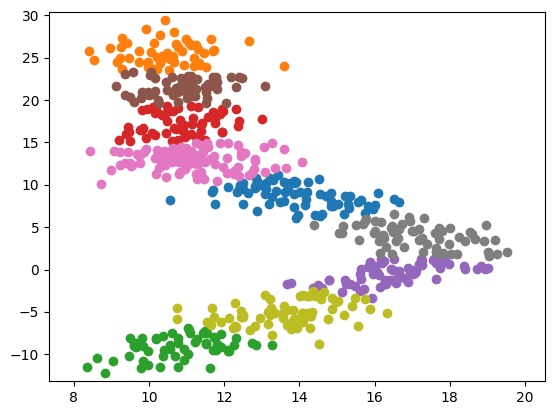

In [7]:
optimal_centroids = [] # Almacena los centroides de la configuración óptima relativa hallada
labels = [] # Almacena el índice de el clúster al que está asignado cada punto
optimal_centroids, labels, optimal_clusters = executeAndShowKmeans(10)
accumulated_reasigned_points = 0 # Indica cuantos puntos se han reasignado desde que se realizó la última clusterización

A continuación, se muestra la variación de los puntos del clúster en el tiempo.

9
Mostrando:
Recalculado


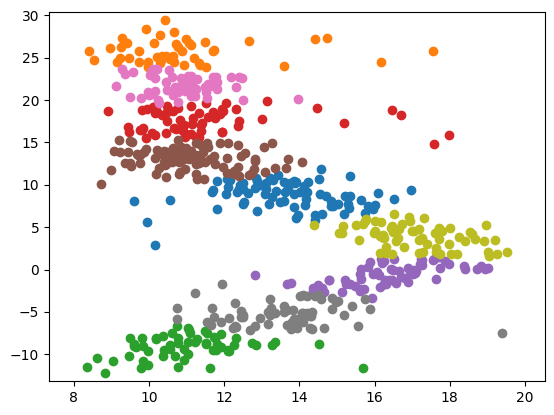

7
Mostrando:
Recalculado


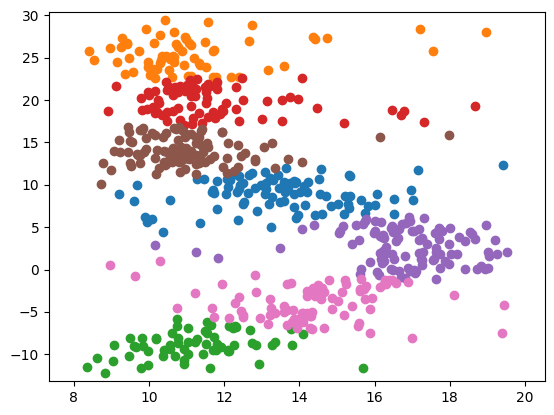

4
Mostrando:
Recalculado


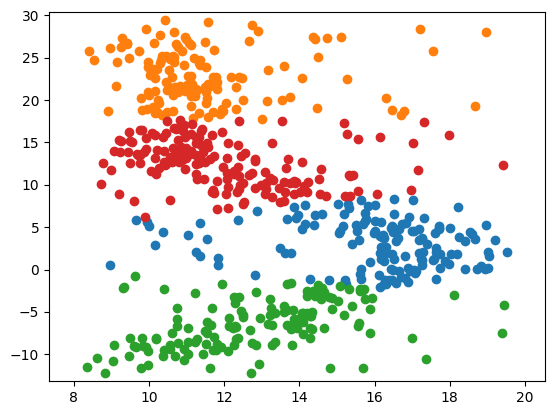

4
Mostrando:
Recalculado


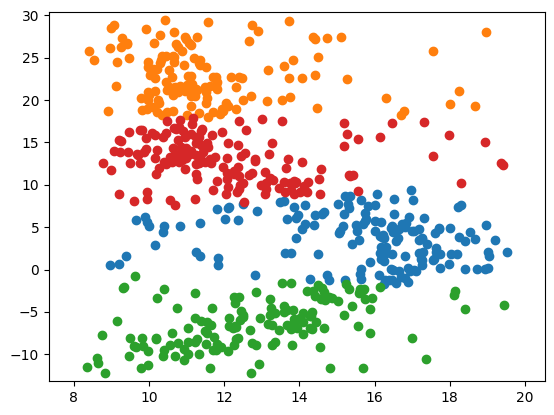

4
Mostrando:
Recalculado


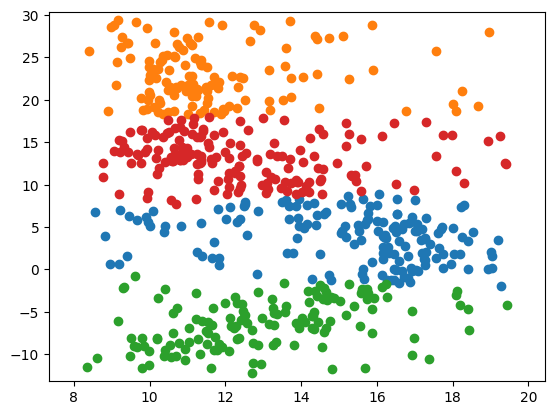

4
Mostrando:
Recalculado
[(69, 0), (87, 0), (91, 0), (92, 0), (97, 0), (120, 1), (180, 1), (204, 0), (207, 3), (219, 1), (226, 3), (239, 2), (240, 0), (253, 3), (264, 0), (291, 3), (313, 0), (318, 3), (330, 0), (350, 0), (357, 0), (362, 3), (381, 3), (413, 0), (426, 3), (432, 1), (500, 3), (529, 0), (588, 2)]


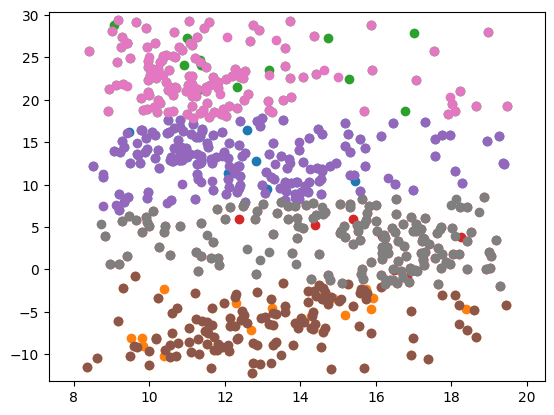

4
Mostrando:
Recalculado


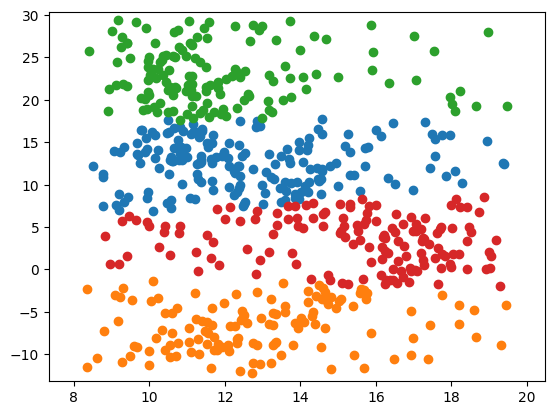

In [8]:
for i in range(0, 8):
    old_x = x.copy()
    old_y = y.copy()
    x.clear()
    y.clear()
    movePoints(old_x, old_y, 10, 0.5) # Mueve los puntos con un valor de 20% de probabilidad de èxito para cada punto

    # Variated guarda el valor booleano acerca de si variaron el número de puntos suficientes
    # Reasigned_points guarda los puntos que variaron para modificarlos en el clúster correspondiente
    # Considero que el dataset ha variado sí hay un 10% de puntos que han cambiado su cluster
    reasigned_points, variated = hasSignificantVariation((old_x, old_y, point_class), (x, y, point_class), optimal_centroids, labels)
    accumulated_reasigned_points = accumulated_reasigned_points + len(reasigned_points) 
    
    # Reconfiguramos los clusters si muchos puntos han cambiado de cluster en un mismo instante, o si llevamos una acumulación de puntos movidos
    # desde la última reconfiguración de al menos el 5% de los puntos del dataset.
    if(accumulated_reasigned_points > (len(labels) * 0.05) or variated):
        optimal_centroids, labels, optimal_clusters = executeAndShowKmeans(20)
        print("Recalculado")
        accumulated_reasigned_points = 0
    else: # Si no ha variado lo suficiente, reasignamos los puntos a los clusteres correspodientes y los representamos
        print(reasigned_points)
        labels = reasign_and_show(reasigned_points, labels)